In [1]:
%matplotlib inline
import pandas as pd
import cx_Oracle as oracle
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [20]:
df_budan_reason=pd.read_excel('data/补单原因.xls')
df_time=pd.read_excel('data/华广订单时间统计.xls')
df_huaguang_order_num=pd.read_excel('data/华广下单数量.xls')
df_yuanfang_order_num=pd.read_excel('data/园方下单数量.xls')

In [21]:
df_yuanfang_order_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 5 columns):
门店名称     129 non-null object
门店号      129 non-null int64
圆方下单量    129 non-null int64
圆方退回量    114 non-null float64
圆方补单量    54 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 5.1+ KB


In [22]:
df_yuanfang_order_num.head()

,门店名称,门店号,圆方下单量,圆方退回量,圆方补单量
0,河北石家庄红星店,13010001,51,48.0,4.0
1,河北唐山丰南红星店,13020001,9,8.0,1.0
2,河北沧州任丘沿街店,13090001,11,6.0,NaN
3,山西太原雅阁瑞普店,14010001,62,60.0,2.0
4,内蒙古呼和浩特金盛店,15010001,19,38.0,2.0


In [23]:
df_use_huaguang=df_yuanfang_order_num.merge(df_huaguang_order_num).dropna(subset=['圆方下单量']).fillna(0)

In [6]:
print(str(len(df_use_huaguang)/len(df_yuanfang_order_num))+" use huaguang")

0.6046511627906976 use huaguang


# 补单比较

* 补单效果=同一门店华广单补单率-圆方单补单率
* 华广补单率高：补单效果>0华广单补单率更高，且数值越大华广补单率和圆方补单率相差越大
* 华广补单率低：补单效果<0华广单补单率更低，且数值越大华广补单率和圆方补单率相差越大
* 补单效果=0华广单补单率和圆方单补单率一致

In [90]:
df_use_huaguang.eval('''
                   圆方退回率= 圆方退回量/圆方下单量
                   华广退回率= 华广退回量/华广下单量
                   圆方补单率=圆方补单量/圆方下单量
                   华广补单率=华广补单量/华广下单量
                   补单效果=华广补单率-圆方补单率
                   退回效果=华广退回率-圆方退回率
''',inplace=True)
df_use_huaguang.head()

,门店名称,门店号,圆方下单量,圆方退回量,圆方补单量,华广下单量,华广退回量,华广补单量,圆方退回率,华广退回率,圆方补单率,华广补单率,补单效果,退回效果
0,河北唐山丰南红星店,13020001,9,8.0,1.0,1,0.0,0.0,0.888889,0.000000,0.111111,0.000000,-0.111111,-0.888889
1,山西太原雅阁瑞普店,14010001,62,60.0,2.0,27,18.0,0.0,0.967742,0.666667,0.032258,0.000000,-0.032258,-0.301075
2,辽宁沈阳居然之家店,21010001,47,78.0,0.0,1,2.0,0.0,1.659574,2.000000,0.000000,0.000000,0.000000,0.340426
3,上海嘉定区店,31010002,11,22.0,0.0,111,84.0,8.0,2.000000,0.756757,0.000000,0.072072,0.072072,-1.243243
4,上海松江区乐迎门店,31010005,115,126.0,16.0,8,3.0,0.0,1.095652,0.375000,0.139130,0.000000,-0.139130,-0.720652


In [89]:
all_orders=len(df_use_huaguang)
orders_1=len(df_use_huaguang.query('补单效果>0'))
orders_2=len(df_use_huaguang.query('补单效果<0'))
orders_3=len(df_use_huaguang.query('补单效果==0'))
print('共{}家门店'.format(all_orders))
print('{}家门店圆方补单率更高,占比{:.2%}'.format(orders_1,orders_1/all_orders))
print('{}家门店华广补单率更高,占比{:.2%}'.format(orders_2,orders_2/all_orders))
print('{}家门店华广补单率一样,占比{:.2%}'.format(orders_3,orders_3/all_orders))

共78家门店
24家门店圆方补单率更高,占比30.77%
25家门店华广补单率更高,占比32.05%
29家门店华广补单率一样,占比37.18%


* 共78家门店
* 24家门店圆方补单率更高,占比30.77%
* 25家门店华广补单率更高,占比32.05%
* 29家门店华广补单率一样,占比37.18%

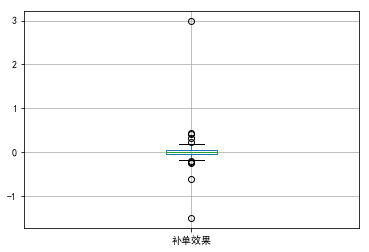

In [36]:
df_use_huaguang.sort_values(['门店号'])[['补单效果']].boxplot()

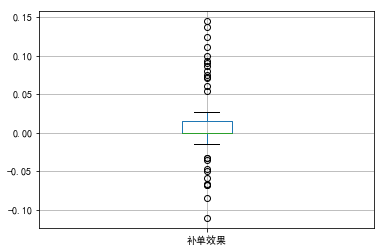

In [216]:
df_use_huaguang[
    (df_use_huaguang['补单效果']>mild_outlier)
    &
    (df_use_huaguang['补单效果']<extreme_outlier)
][['补单效果']].boxplot()

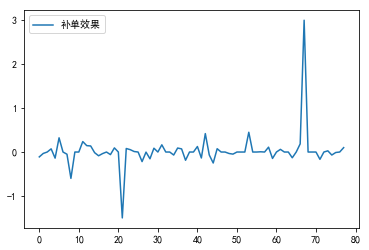

In [37]:
df_use_huaguang.sort_values(['门店号'])[['补单效果']].plot()

In [38]:
#取得边缘区间
tmp=df_use_huaguang.sort_values(['门店号'])[['补单效果']].describe()['补单效果']
IQR=tmp[6]-tmp[4]
mild_outlier,extreme_outlier=tmp[4]-IQR,tmp[6]+IQR
mild_outlier,extreme_outlier

(-0.12920615420615422, 0.15305516555516557)

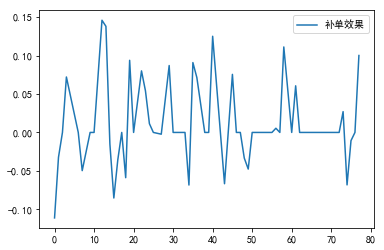

In [198]:
df_use_huaguang[
    (df_use_huaguang['补单效果']>mild_outlier)
    &
    (df_use_huaguang['补单效果']<extreme_outlier)
][['补单效果']].plot()

# 退单比较

* 退单效果=同一门店华广单退回率-圆方单退回率
* 华广退单率高：退单效果>0华广单退回率更高，且数值越大华广退回率和圆方退回率相差越大
* 华广退单率低：退单效果<0华广单退回率更低，且数值越大华广退回率和圆方退回率相差越大
* 退单效果=0华广单退回率和圆方单退回率一致

In [93]:
all_orders=len(df_use_huaguang)
orders_1=len(df_use_huaguang.query('退回效果>0'))
orders_2=len(df_use_huaguang.query('退回效果<0'))
orders_3=len(df_use_huaguang.query('退回效果==0'))
print('共{}家门店'.format(all_orders))
print('{}家门店华广退回率更高,占比{:.2%}'.format(orders_1,orders_1/all_orders))
print('{}家门店圆方退回率更高,占比{:.2%}'.format(orders_2,orders_2/all_orders))
print('{}家门店华广，圆方退回率一样,占比{:.2%}'.format(orders_3,orders_3/all_orders))

共78家门店
32家门店华广退回率更高,占比41.03%
43家门店圆方退回率更高,占比55.13%
3家门店华广，圆方退回率一样,占比3.85%


* 共78家门店
* 32家门店华广退回率更高,占比41.03%
* 43家门店圆方退回率更高,占比55.13%
* 3家门店华广，圆方退回率一样,占比3.85%

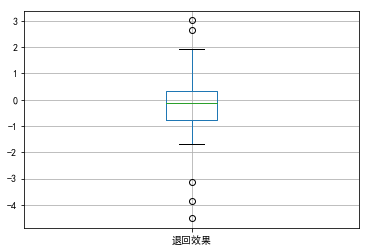

In [191]:
df_use_huaguang.sort_values(['门店号'])[['退回效果']].boxplot()

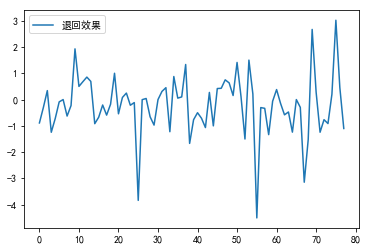

In [199]:
df_use_huaguang.sort_values(['门店号'])[['退回效果']].plot()

In [192]:
#取得边缘区间
tmp=df_use_huaguang.sort_values(['门店号'])[['退回效果']].describe()['退回效果']
IQR=tmp[6]-tmp[4]
mild_outlier,extreme_outlier=tmp[4]-IQR,tmp[6]+IQR
mild_outlier,extreme_outlier

(-1.840085011803056, 1.419092657877212)

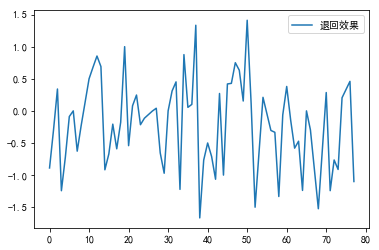

In [193]:
df_use_huaguang[
    (df_use_huaguang['退回效果']>mild_outlier)
    &
    (df_use_huaguang['退回效果']<extreme_outlier)
][['退回效果']].plot()

# 生产时间

In [47]:
df_time['建单_入库']=abs(pd.to_datetime(df_time['建单时间'])-pd.to_datetime(df_time['入库时间'])).dt.days
df_time['建单_出库']=abs(pd.to_datetime(df_time['建单时间'])-pd.to_datetime(df_time['出库时间'])).dt.days

In [48]:
df_time[pd.notnull(df_time['建单_入库'])][['建单_入库']].describe()

,建单_入库
count,673.000000
mean,44.909361
std,8.427163
min,7.000000
25%,42.000000
50%,46.000000
75%,50.000000
max,63.000000


In [49]:
df_time.query('建单_入库==建单_入库.min()')

,订单号,门店名称,门店号,建单时间,入库时间,出库时间,建单-入库,建单-出库,建单_入库,建单_出库
2060,1341500011807080004,安徽六安金安万达店,34150001,7/8/2018 17:12:52,7/16/2018 13:32:51,7/29/2018 08:36:21,7.0,20.0,7.0,20.0


In [50]:
df_time.query('建单_入库==建单_入库.max()')

,订单号,门店名称,门店号,建单时间,入库时间,出库时间,建单-入库,建单-出库,建单_入库,建单_出库
1535,1320900011806070001,江苏盐城建材店,32090001,6/7/2018 20:15:02,8/10/2018 08:40:13,8/11/2018 14:48:16,63.0,64.0,63.0,64.0


In [52]:
df_use_huaguang.head(1)

,门店名称,门店号,圆方下单量,圆方退回量,圆方补单量,华广下单量,华广退回量,华广补单量,圆方退回率,华广退回率,圆方补单率,华广补单率,补单效果
0,河北唐山丰南红星店,13020001,9,8.0,1.0,1,0.0,0.0,0.888889,0.0,0.111111,0.0,-0.111111


In [310]:
df_use_huaguang.query('130>华广下单量>100')

,门店名称,门店号,圆方下单量,圆方退回量,圆方补单量,华广下单量,华广退回量,华广补单量,圆方退回率,华广退回率,圆方补单率,华广补单率,效果,补单效果,退回效果
3,上海嘉定区店,31010002,11,22.0,0.0,111,84.0,8.0,2.0,0.756757,0.0,0.072072,0.072072,0.072072,-1.243243


In [313]:
df_use_huaguang.query('华广下单量>100 or 华广下单量<130')

,门店名称,门店号,圆方下单量,圆方退回量,圆方补单量,华广下单量,华广退回量,华广补单量,圆方退回率,华广退回率,圆方补单率,华广补单率,效果,补单效果,退回效果
3,上海嘉定区店,31010002,11,22.0,0.0,111,84.0,8.0,2.000000,0.756757,0.000000,0.072072,0.072072,0.072072,-1.243243
7,江苏无锡锡沪东路店,32020002,141,156.0,7.0,144,69.0,0.0,1.106383,0.479167,0.049645,0.000000,-0.049645,-0.049645,-0.627216
27,浙江省杭州市萧山区展示设计中心,33010005,879,430.0,2.0,132,70.0,0.0,0.489192,0.530303,0.002275,0.000000,-0.002275,-0.002275,0.041111


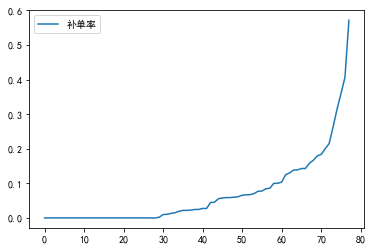

In [55]:
df_use_huaguang.eval('补单率=(华广补单量+圆方补单量)/(华广下单量+圆方下单量)').sort_values('补单率').reset_index()[['补单率']].plot()